# Demonstrate full circle wide field imaging

This include prediction of components, inversion, point source fitting. We will compare the output images with the input models, looking for closeness in flux and position.

In [1]:
%matplotlib inline

import os
import sys
import copy

sys.path.append(os.path.join('..', '..'))

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.convolution import Gaussian2DKernel, convolve

from astropy.coordinates import SkyCoord, CartesianRepresentation
from astropy.time import Time
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from arl.visibility.operations import create_visibility, sum_visibility
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration

from matplotlib import pyplot as plt

from arl.skymodel.operations import create_skycomponent, find_skycomponents, fit_skycomponent, \
    find_nearest_component, insert_skycomponent
from arl.image.operations import show_image, export_image_to_fits, qa_image
from arl.image.iterators import raster_iter
from arl.util.testing_support import create_named_configuration
from arl.fourier_transforms.ftprocessor import *

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)

Construct the SKA1-LOW core configuration

In [2]:
lowcore = create_named_configuration('LOWBD2-CORE')

We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [3]:
times = numpy.arange(- numpy.pi / 4.0, + numpy.pi * 1.001 / 4.0, numpy.pi / 8.0)
frequency = numpy.array([1e8])
reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+180.0 * u.deg, dec=-60.0 * u.deg, frame='icrs', equinox=2000.0)

params = {'npixel':256,
          'cellsize': 0.001,
          'npol': 1,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8}

vt = create_visibility(lowcore, times, frequency, weight=1.0, phasecentre=phasecentre, params=params)

Fill in the visibility with exact calculation of a number of point sources

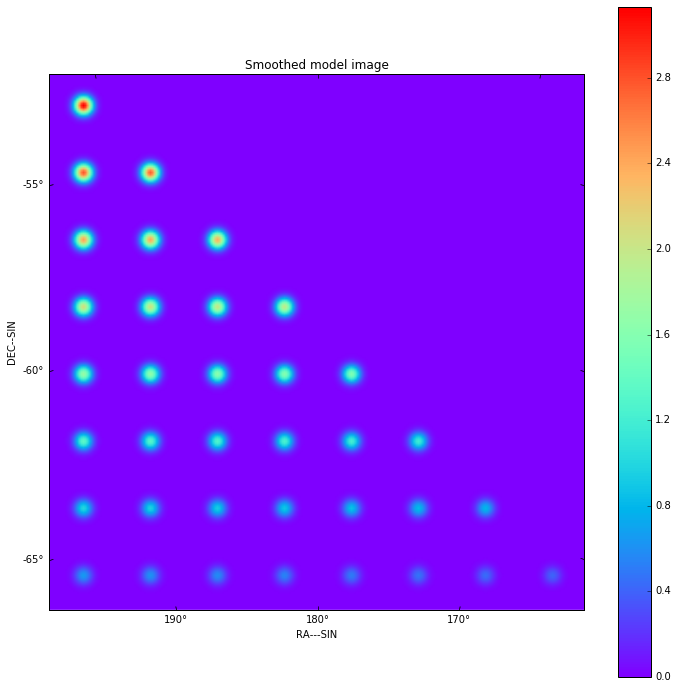

In [4]:
vt.data['vis'] *= 0.0

model = create_image_from_visibility(vt, params=params)
centre = model.wcs.wcs.crpix-1
spacing_pixels = params['npixel'] // 8
log.info('Spacing in pixels = %s' % spacing_pixels)
spacing = model.wcs.wcs.cdelt * spacing_pixels
dopoint=False
if dopoint:
    centers = [-2.5]
else:
    centers = [-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]

original_comps = []
# We calculate the source positions in pixels and then calculate the
# world coordinates to put in the skycomponent description
for iy in centers:
    for ix in centers:
        if ix >= iy:
            p = int(round(centre[0] + ix * spacing_pixels * numpy.sign(model.wcs.wcs.cdelt[0]))), \
                int(round(centre[1] + iy * spacing_pixels * numpy.sign(model.wcs.wcs.cdelt[1])))
            sc = pixel_to_skycoord(p[0], p[1], model.wcs)
            log.info("Component at (%f, %f) [0-rel] %s" % (p[0], p[1], str(sc)))
            flux = numpy.array([[100.0 + 2.0 * ix + iy * 20.0]])
            comp = create_skycomponent(flux=flux, frequency=frequency, direction=sc)
            original_comps.append(comp)
            predict_skycomponent_visibility(vt, comp)
            insert_skycomponent(model, comp, params)
        
cmodel = create_image_from_array(convolve(model.data[0,0,:,:], Gaussian2DKernel(3.0), normalize_kernel=True), 
                                 model.wcs)
show_image(cmodel)
plt.title("Smoothed model image")
plt.show()



Predict the visibility using the different approaches.

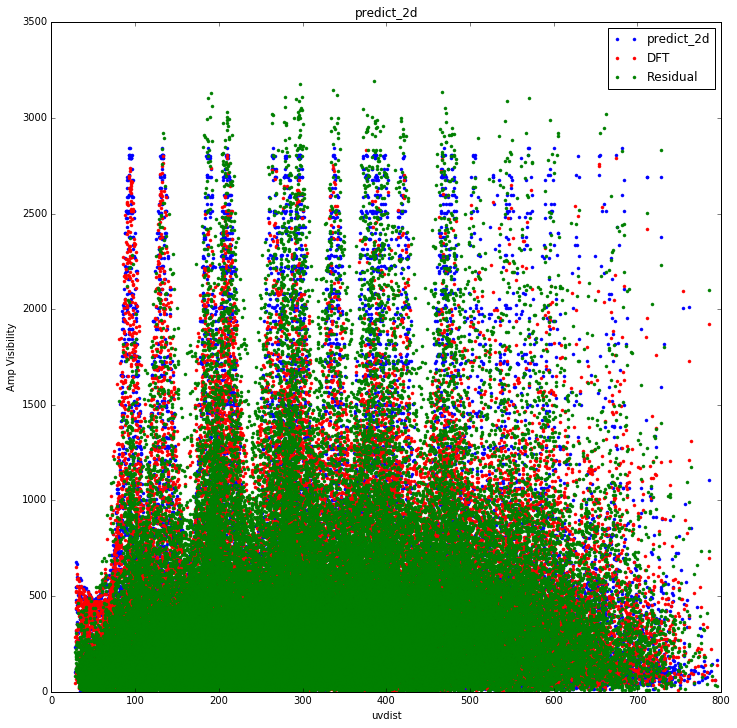

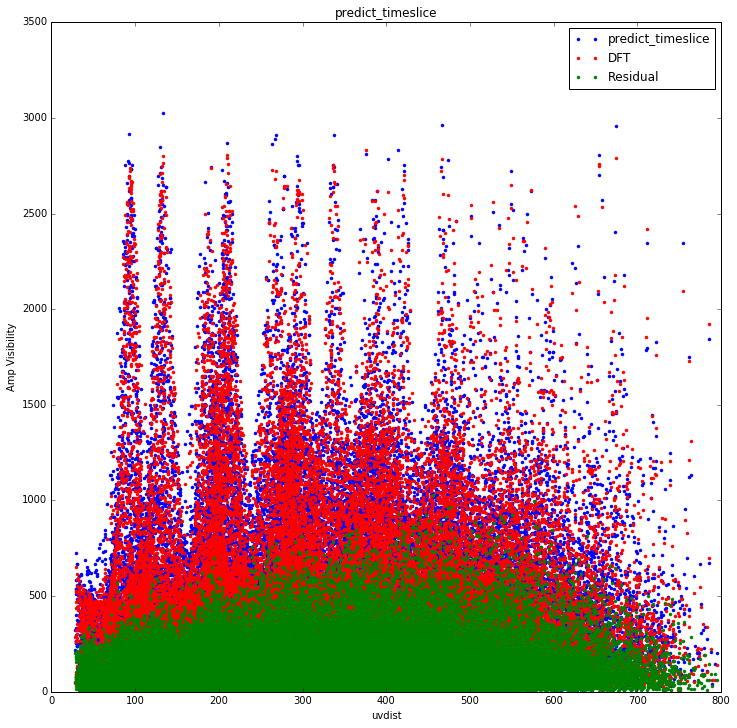

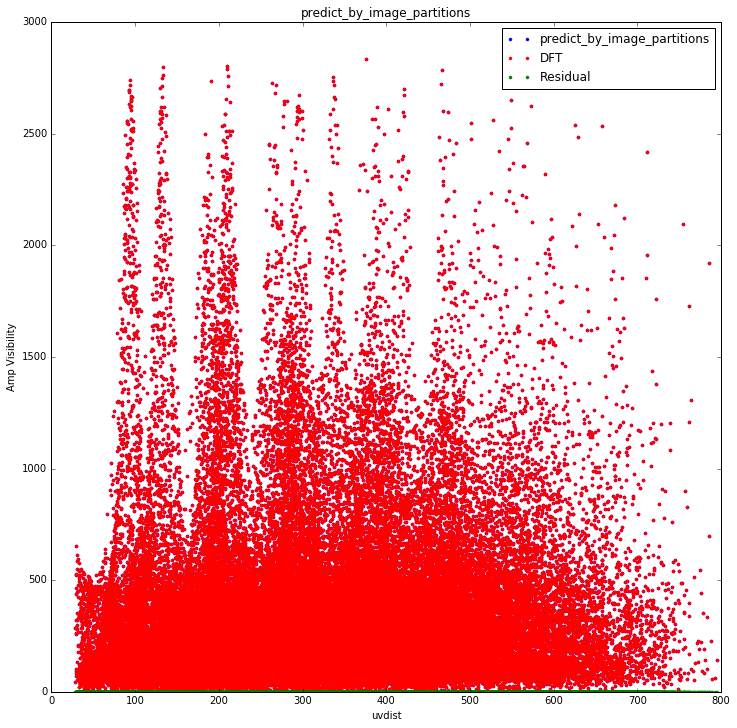

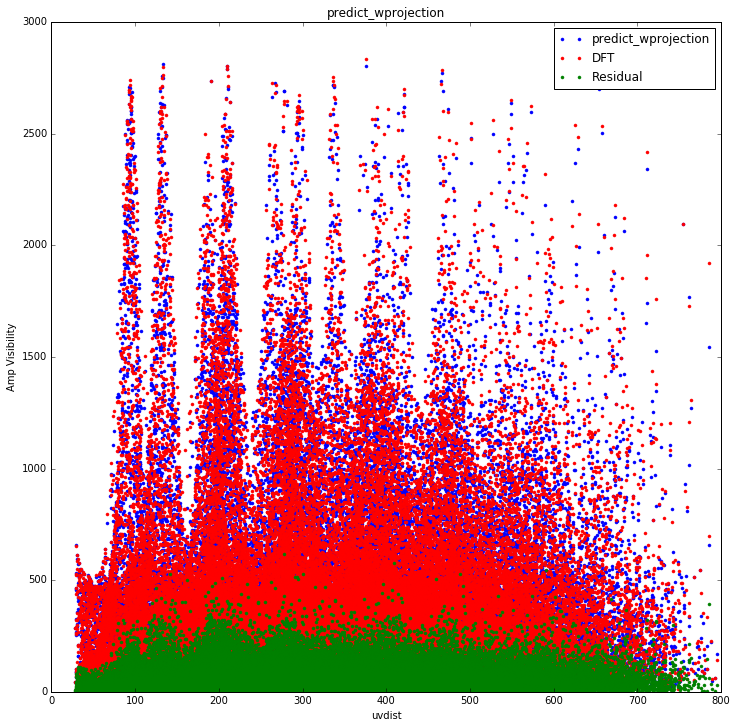

In [ ]:
processors = [predict_2d, predict_timeslice, predict_by_image_partitions, predict_wprojection]

for processor in processors:

    vtpredict = create_visibility(lowcore, times, frequency, weight=1.0, phasecentre=phasecentre, params=params)
    
    params = {'npixel': 256,
              'npol': 1,
              'cellsize': 0.001,
              'spectral_mode': 'channel',
              'channelwidth': 5e7,
              'reffrequency': 1e8,
              'timeslice': 1.0,
              'padding':2,
              'oversampling':4,
              'nprocessor':1,
              'image_partitions':8,
              'wstep':2.0, 
              'context':"imaging-fits notebook, using processor %s" %(processor.__name__)
             }

    vtpredict = processor(vtpredict, model, params=params)
    
    
    uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
    plt.clf()
    plt.plot(uvdist, numpy.abs(vtpredict.data['vis'][:,0,0]), '.', color='b', label=processor.__name__)
    plt.plot(uvdist, numpy.abs(vt.data['vis'][:,0,0]), '.', color='r', label="DFT")   
    plt.plot(uvdist, numpy.abs(vtpredict.data['vis'][:,0,0]-vt.data['vis'][:,0,0]), '.', color='g', label="Residual")

    plt.xlabel('uvdist')
    plt.ylabel('Amp Visibility')
    plt.legend()
    plt.title(processor.__name__)
    plt.show()



Make the image using the different approaches. We will evaluate the results using a number of plots:

- The recovered flux versus distance from phase centre. We show two forms: the result fitted and the result from a DFT at the expected position. The ideal result would be a straight line: flux=100.0
- The offset in RA versus the offset in DEC. The ideal result is a cluster around 0 pixels.
- The fitted flux versus the DFT flux. The ideal result is a straightline fitted: flux = DFT flux

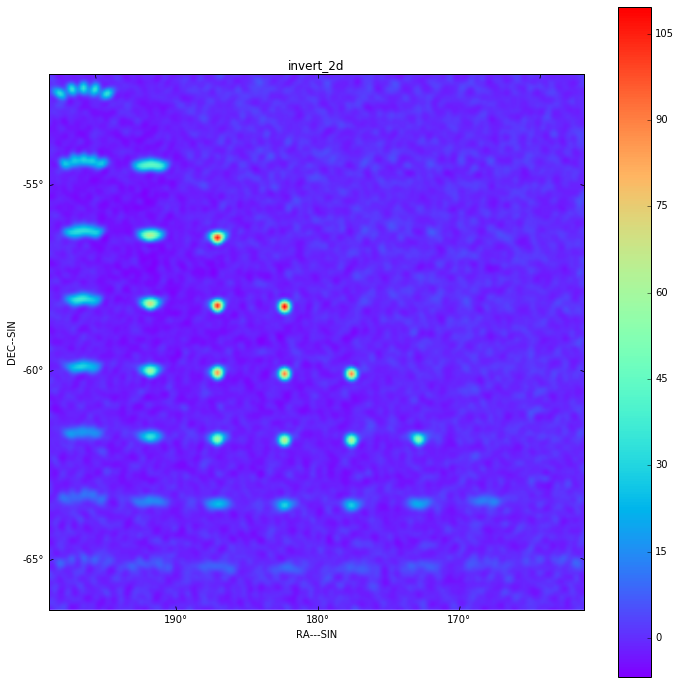

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor invert_2d
	Data:
		sum: 3400.89251828
		max: 109.636905614
		medianabs: 1.37964471762
		median: -0.684820541667
		min: -6.76480945258
		rms: 5.15647773034



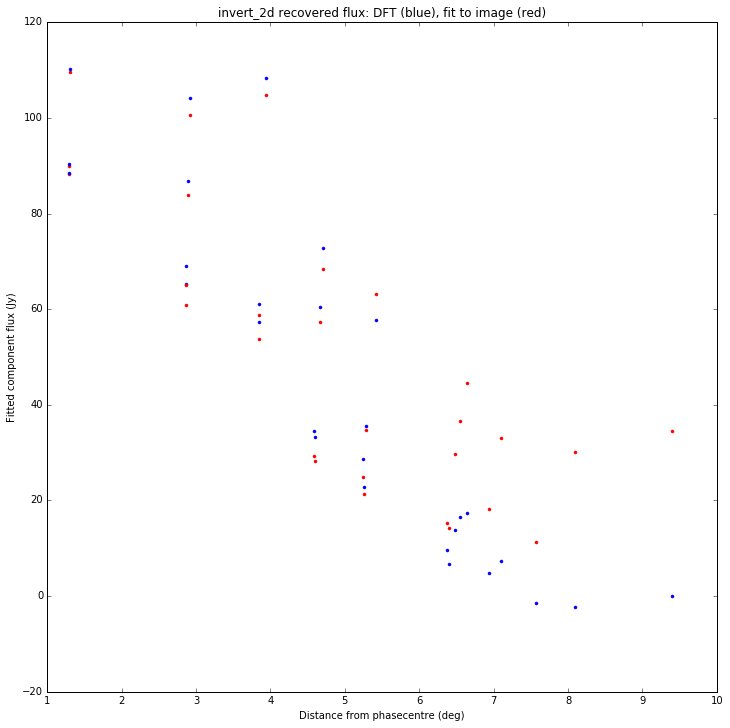

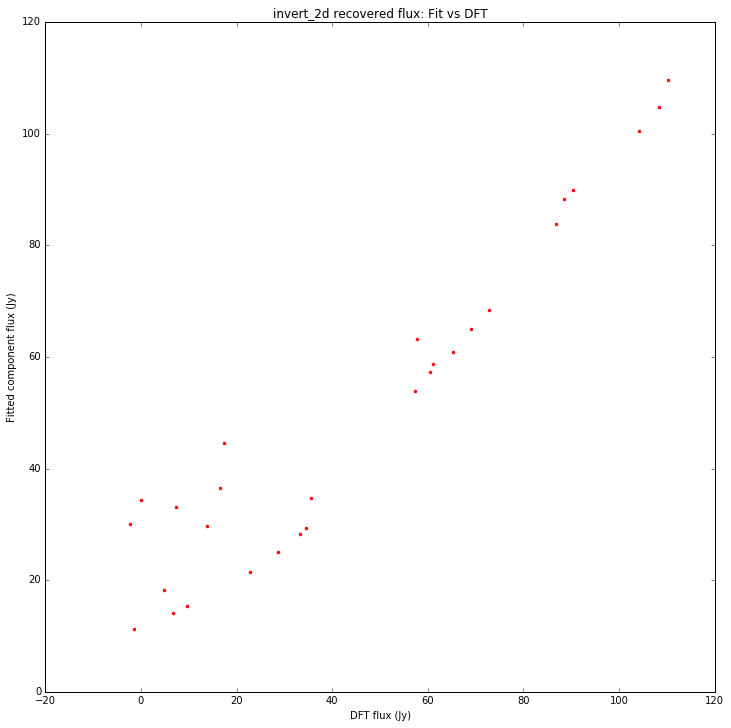

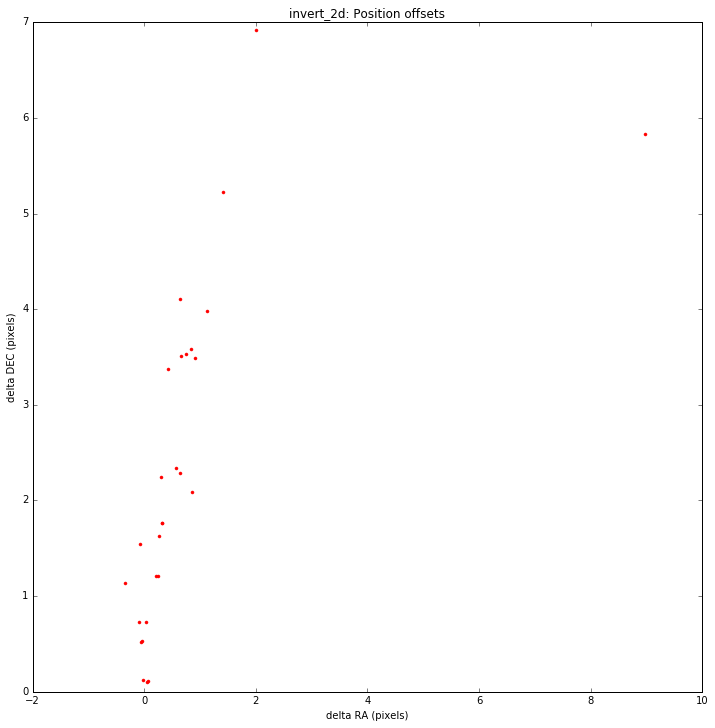

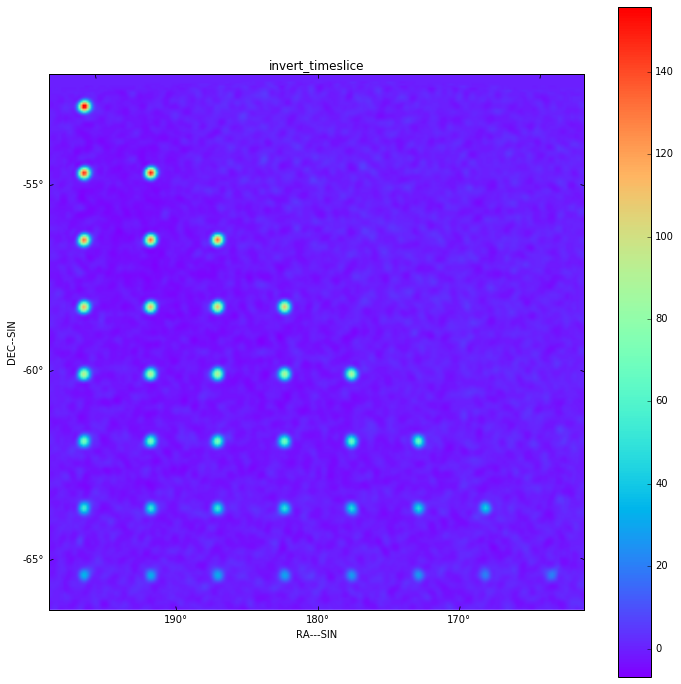

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor invert_timeslice
	Data:
		sum: 4545.90580203
		max: 155.665790304
		medianabs: 1.29051007921
		median: -0.694002843758
		min: -6.8374429919
		rms: 6.89314324745



In [ ]:
processors = [invert_2d, invert_timeslice, invert_by_image_partitions, invert_wprojection]

for processor in processors:

    params = {'npixel': 256,
              'npol': 1,
              'cellsize': 0.001,
              'spectral_mode': 'channel',
              'channelwidth': 5e7,
              'reffrequency': 1e8,
              'timeslice': 1.0,
              'padding':2,
              'oversampling':32,
              'nprocessor':1,
              'image_partitions':8,
              'wstep':2.0, 
              'context':"imaging-fits notebook, using processor %s" %(processor.__name__)
             }

    targetimage = create_image_from_visibility(vt, params=params)
    targetimage, sumwt = processor(vt, targetimage, params=params)

    targetimage.data /= sumwt
    
    show_image(targetimage)
    plt.title(processor.__name__)
    plt.show()
    
    print("Dirty Image %s" % qa_image(targetimage, params))
    
    export_image_to_fits(targetimage, 'imaging-fits_dirty_%s.fits' %(processor.__name__))

    comps = find_skycomponents(targetimage, fwhm=1.0, threshold=10.0, npixels=5, params=None)
    plt.clf()
    for comp in comps:
        distance = comp.direction.separation(model.phasecentre)
        plt.plot(distance.deg, comp.flux[0,0], '.', color='r') 
        plt.plot(distance.deg, sum_visibility(vt, comp.direction, params=None)[0], '.', color='b')
    plt.xlabel('Distance from phasecentre (deg)')
    plt.ylabel('Fitted component flux (Jy)')
    plt.title("%s recovered flux: DFT (blue), fit to image (red)" % (processor.__name__))
    plt.show()
    plt.clf()

    for comp in comps:
        plt.plot(sum_visibility(vt, comp.direction, params=None)[0], comp.flux[0,0], '.', color='r')
    plt.ylabel('Fitted component flux (Jy)')
    plt.xlabel('DFT flux (Jy)')
    plt.title("%s recovered flux: Fit vs DFT" % (processor.__name__))
    plt.show()

    checkpositions = True
    if checkpositions:
        plt.clf()
        for i in range(len(comps)):
            ocomp = find_nearest_component(comps[i].direction, original_comps)
            plt.plot((comps[i].direction.ra.value  - ocomp.direction.ra.value)/targetimage.wcs.wcs.cdelt[0], 
                     (comps[i].direction.dec.value - ocomp.direction.dec.value)/targetimage.wcs.wcs.cdelt[1], 
                     '.', color='r')  

        plt.xlabel('delta RA (pixels)')
        plt.ylabel('delta DEC (pixels)')
        plt.title("%s: Position offsets" % (processor.__name__))
        plt.show()
    
